# SVD在推荐系统中的应用

有一个风味美食平台，经营着多种不同风味儿的地方特色美食。

在系统中维护着一个原始的打分表，其中表中的行表示各个用户。

列表示各种菜品，每一个用户在对一个菜品消费之后都会对其进行打分，分数为1分~5分，分数越高表示评价越高。

如果该用户没有消费某道菜品，则分数值默认为0分。

在我们的例子中，一共有18名用户对11个不同的菜品进行了打分评价，原始的打分数据如下：

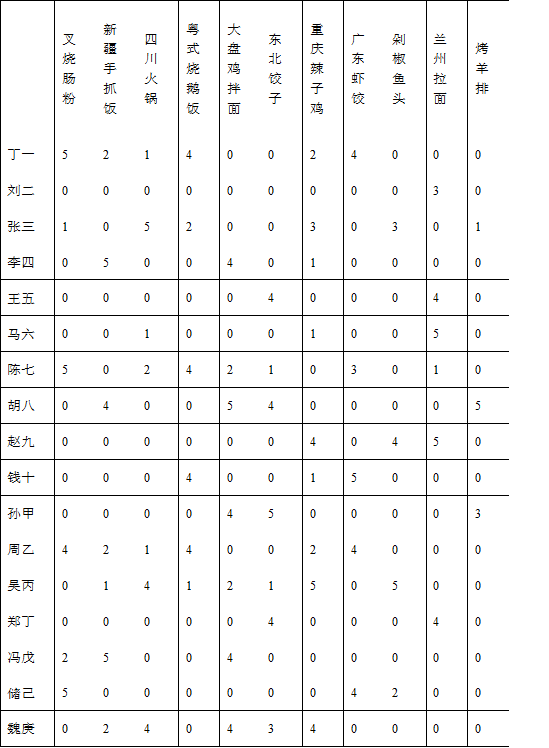

推荐系统到底应该推荐什么。答案很简单：就是聚焦用户没有消费过的菜品（也就是没有打过分的那些菜品），通过模型评估，分析出某个具体用户可能会喜欢的菜品，然后推荐给他，达到最大可能引导消费的目的。

那么归结起来这里面关键的技术点有三条：
- （1）衡量菜品之间的相似性
- （2）评分估计
- （3）稀疏评分矩阵的处理


# 衡量菜品之间的相似性
两个菜品，我们通过不同用户对其的打分，将其量化成一个分数向量，然后通过对两个菜品的分数向量进行分析比较，定量的进行两个菜品的相似度计算。计算相似度的方法有很多，例如，有欧式距离、皮尔逊相关系数、余弦相似度等等。
这里，我们采用余弦相似度的方法，来定量分析两个商品的相似程度。

# 真实稀疏数据矩阵的降维处理
我们在计算每两道菜之间的余弦相似度的时候，必须要求找到同时吃过这两道菜的所有顾客为其所打的分值，换句话说，就是参与相似度计算的分数向量的每个元素都必须非零，且来自于相同的几个顾客。

是否依据数据矩阵的实际打分情况，按行对原始打分矩阵进行压缩降维，将其处理成一个低维的矩阵，然后再对其进行余弦相似度的处理呢，这样就能避免上面描述的稀疏矩阵的一些不足。

我们通过行压缩的方式，对矩阵进行行压缩，在行压缩的基础上，推荐算法中通常还需要再乘以奇异值方阵，赋予其对应的权重值，最终获取降维后规模为6×11行压缩矩阵scoreDataRC 。


# 评分估计
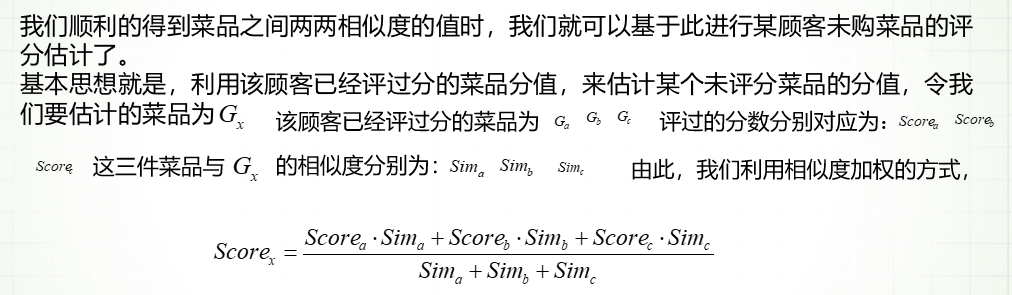

In [2]:
import numpy as np

#这里我们为了大家直观的理解，构建了评分矩阵，实际应用中往往会从数据库中读取数据
scoreData = np.mat([
[5,2,1,4,0,0,2,4,0,0,0],
[0,0,0,0,0,0,0,0,0,3,0],
[1,0,5,2,0,0,3,0,3,0,1],
[0,5,0,0,4,0,1,0,0,0,0],
[0,0,0,0,0,4,0,0,0,4,0],
[0,0,1,0,0,0,1,0,0,5,0],
[5,0,2,4,2,1,0,3,0,1,0],
[0,4,0,0,5,4,0,0,0,0,5],
[0,0,0,0,0,0,4,0,4,5,0],
[0,0,0,4,0,0,1,5,0,0,0],
[0,0,0,0,4,5,0,0,0,0,3],
[4,2,1,4,0,0,2,4,0,0,0],
[0,1,4,1,2,1,5,0,5,0,0],
[0,0,0,0,0,4,0,0,0,4,0],
[2,5,0,0,4,0,0,0,0,0,0],
[5,0,0,0,0,0,0,4,2,0,0],
[0,2,4,0,4,3,4,0,0,0,0],
[0,3,5,1,0,0,4,1,0,0,0]
])

#通过余弦相似度来对两个菜进行相似度判定
def cosSim(vec_1, vec_2):
    dotProd = float(np.dot(vec_1.T, vec_2))
    normProd = np.linalg.norm(vec_1)*np.linalg.norm(vec_2)
    return 0.5+0.5*(dotProd/normProd)

#根据用户的打分情况对新蔡的得分进行预测
def estScore(scoreData,scoreDataRC,userIndex,itemIndex):
    n = np.shape(scoreData)[1]
    simSum = 0
    simSumScore = 0
    for i in range(n):
        userScore = scoreData[userIndex,i]
        if userScore == 0 or i == itemIndex:
            continue
        sim = cosSim(scoreDataRC[:, i], scoreDataRC[:, itemIndex])
        simSum = float(simSum + sim)
        simSumScore = simSumScore + userScore * sim
    if simSum == 0:
        return 0
    return simSumScore / simSum

#通过svd分解对矩阵进行降维
U, sigma, VT = np.linalg.svd(scoreData)
sigmaSum = 0
k_num = 0
#如果取出的奇异值的数量超过了设定的百分比，则退出循环
for k in range(len(sigma)):
    sigmaSum = sigmaSum + sigma[k] * sigma[k]
    if float(sigmaSum)/float(np.sum(sigma ** 2)) > 0.9:
        k_num = k+1
        break
#根据前percentage比例的奇异值重构得分矩阵，压缩信息
sigma_K = np.mat(np.eye(k_num)*sigma[:k_num])
scoreDataRC = sigma_K * U.T[:k_num, :] * scoreData

n = np.shape(scoreData)[1]
userIndex = 17

for i in range(n):
    userScore = scoreData[17, i]
    if userScore != 0:
        continue
    print("index:{},score:{}".format(i, estScore(scoreData, scoreDataRC, userIndex, i)))

index:0,score:2.6347116715331165
index:4,score:2.9259893459771127
index:5,score:2.933723884808588
index:8,score:2.9657073178482753
index:9,score:2.9057073432965526
index:10,score:2.926348465526288


In [ ]:
scoreData.shape()